In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn import preprocessing
import random
import seaborn as sns
import skbio.diversity.alpha as alpha


/Users/Diana_Gong/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/Diana_Gong/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### Importing OTU table, normalization (change to relative abundances), set training and testing groups

In [2]:
# Import data into a pandas dataframe
otu_table = pd.read_csv('EGAD00001003453.otu_table.99.denovo', sep='\t', header=0, index_col=0)

#Transpose OTU table so that samples are rows and OTUs are columns
otu_table = otu_table.T

#Convert to relative abundances
#Normalize each person to 1 (change to relative abundances)
otu_table_normalized = otu_table.div(otu_table.sum(axis=1), axis=0)

In [3]:
#Make training and testing sets (50/50 for now)

#Scramble existing table with hard-coded random seed
otu_table_normalized = otu_table_normalized.sample(frac=1, random_state=1)

#Make first half training and second half testing
total_people = otu_table_normalized.shape[0]
print(total_people)
midway = total_people/2
training_table = otu_table_normalized.iloc[0:int(midway)]
testing_table = otu_table_normalized.iloc[int(midway):]


1010


### Set conditions to test:

In [4]:
N = [5, 10, 25, 40, 50, 60, 75, 100, 200]
weight_setup = ['even', 'uneven_100x', 'uneven_10x', 'uneven_graduated']#, 'uneven_bins']
num_bins = 3

#Number of times to run each condition (N and weight setup)
num_repeats = 30

### Functions

Returns list of weights to multiply by relative abundance matrix according to parameters n and weight

In [5]:
def calculate_weights(n,weight):
    if weight == 'even':
        return [1/n]*n
    elif weight == 'uneven_100x':
        x = 1/(100 + (n-1))
        return [100*x] + [x]*(n-1)
    elif weight == 'uneven_10x':
        x = 1/(10 + (n-1))
        return [10*x] + [x]*(n-1)
    elif weight == 'uneven_graduated':
        decreasing_list = list(range(n,0,-1))
        return [x/sum(decreasing_list) for x in decreasing_list]    

### Master loop: Generate all samples for given conditions

In [6]:
df_list = []
#Generate matrix of random seeds of size num_repeats x len(N), which is how many random numbers are needed for this sampling experiment
random_seed = np.random.randint(0, high=30000, size=(num_repeats,len(N)))

for i in range(num_repeats):
    for j, n in enumerate(N):
        #Generate random sample of size n using generated random seed
        random_sample = training_table.sample(n=n, random_state = random_seed[i][j], replace=True)
        
        for m, weight in enumerate(weight_setup):
            #Set up actual weights
            weight_list = calculate_weights(n,weight)
            
            #Calculate weighted OTU table
            for k in range(n):
                random_sample.iloc[k] = random_sample.iloc[k]*weight_list[k]
                
            #Calculate weighted mean
            indiv_series = random_sample.mean(axis=0)
            
            #Store data + info/metadata as new pandas Series
            sample_name = str(n) + "_" + weight + "_" + str(i)
            sample_number = i*len(N)*len(weight_setup) + j*len(weight_setup) + m
            indiv_series.loc['sample_name'] = sample_name
            indiv_series.loc['N'] = n
            indiv_series.loc['weight_setup'] = weight
            indiv_series.loc['weight_vector'] = weight_list
            indiv_series.loc['random_seed'] = random_seed[i][j]
            
            #Turn Series into a one-line DataFrame
            indiv_df = pd.DataFrame(indiv_series, columns=[str(sample_number)])
            #Add to list of all generated DataFrames with metadata
            df_list.append(indiv_df)
            
#Concatenate list of dataframes into a single dataframe
final_matrix = pd.concat(df_list, axis=1)
print(final_matrix.tail())

                                       0  \
OTU_ID                                     
sample_name                     5_even_0   
N                                      5   
weight_setup                        even   
weight_vector  [0.2, 0.2, 0.2, 0.2, 0.2]   
random_seed                        15814   

                                                               1  \
OTU_ID                                                             
sample_name                                      5_uneven_100x_0   
N                                                              5   
weight_setup                                         uneven_100x   
weight_vector  [0.9615384615384616, 0.009615384615384616, 0.0...   
random_seed                                                15814   

                                                               2  \
OTU_ID                                                             
sample_name                                       5_uneven_10x_0   
N         

In [7]:
#Transpose matrix so that samples are rows and OTUs and metadata are columns
final_matrix = final_matrix.T

In [8]:
#Save final_matrix to a csv file
final_matrix.to_csv('final_matrix.csv')

In [9]:
#otu_table_normalized.max().sort_values(ascending=False)

In [10]:
#final_matrix.iloc[:, :-5].max().sort_values(ascending=False)

In [11]:
final_matrix

OTU_ID,denovo7709,denovo5395,denovo11322,denovo44859,denovo44858,denovo41472,denovo41473,denovo41470,denovo41471,denovo41476,...,denovo22219,denovo22218,denovo43272,denovo32739,denovo32738,sample_name,N,weight_setup,weight_vector,random_seed
0,0,0,0,0,0,0,0,0,0,0,...,0,5.52753e-07,0,0,0,5_even_0,5,even,"[0.2, 0.2, 0.2, 0.2, 0.2]",15814
1,0,0,0,0,0,0,0,0,0,0,...,0,5.31494e-09,0,0,0,5_uneven_100x_0,5,uneven_100x,"[0.9615384615384616, 0.009615384615384616, 0.0...",15814
2,0,0,0,0,0,0,0,0,0,0,...,0,3.79638e-10,0,0,0,5_uneven_10x_0,5,uneven_10x,"[0.7142857142857142, 0.07142857142857142, 0.07...",15814
3,0,0,0,0,0,0,0,0,0,0,...,0,7.59277e-11,0,0,0,5_uneven_graduated_0,5,uneven_graduated,"[0.3333333333333333, 0.26666666666666666, 0.2,...",15814
4,5.20794e-07,8.5873e-08,0,0,0,0,0,0,8.5873e-08,0,...,0,1.38188e-07,0,0,0,10_even_0,10,even,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",25944
5,4.77793e-09,7.87826e-10,0,0,0,0,0,0,7.87826e-10,0,...,0,1.26778e-09,0,0,0,10_uneven_100x_0,10,uneven_100x,"[0.9174311926605505, 0.009174311926605505, 0.0...",25944
6,2.5147e-10,4.14645e-11,0,0,0,0,0,0,4.14645e-11,0,...,0,6.67254e-11,0,0,0,10_uneven_10x_0,10,uneven_10x,"[0.5263157894736842, 0.05263157894736842, 0.05...",25944
7,1.66172e-11,7.539e-13,0,0,0,0,0,0,7.539e-13,0,...,0,6.06595e-12,0,0,0,10_uneven_graduated_0,10,uneven_graduated,"[0.18181818181818182, 0.16363636363636364, 0.1...",25944
8,0,5.18796e-07,0,0,0,0,0,0,0,2.19506e-08,...,2.88138e-08,0,3.31236e-08,3.19508e-08,0,25_even_0,25,even,"[0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.0...",12933
9,0,4.18384e-09,0,0,0,0,0,0,0,1.77021e-10,...,2.32369e-10,0,2.67125e-08,2.57668e-10,0,25_uneven_100x_0,25,uneven_100x,"[0.8064516129032258, 0.008064516129032258, 0.0...",12933


### Look at various metrics from samples

#### Number of OTUs detected per sample

In [12]:
final_matrix['n_otus'] = final_matrix[:final_matrix.shape[0]-5].astype(bool).sum(axis=1).astype(int)

In [13]:
final_matrix_otus_only = final_matrix.iloc[:,:-6]*10000000
final_matrix_otus_only = final_matrix_otus_only.astype(int)

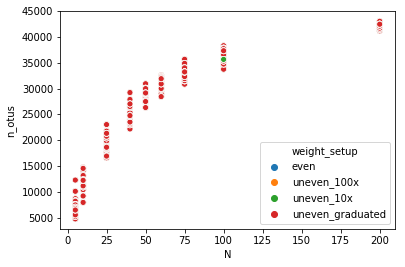

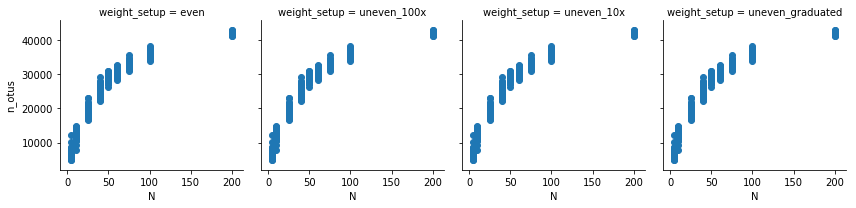

In [14]:
sns.scatterplot(x='N',y='n_otus',hue='weight_setup',data=final_matrix)
plt.show()

g = sns.FacetGrid(col='weight_setup', data=final_matrix)
g.map(plt.scatter, 'N', 'n_otus')
plt.show()

#### Alpha diversity: chao1

In [15]:
final_matrix['chao1'] = [alpha.chao1(list(row),bias_corrected=True) for index, row in final_matrix_otus_only.iterrows()]

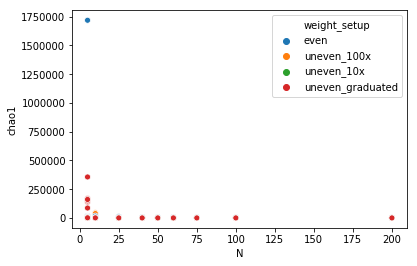

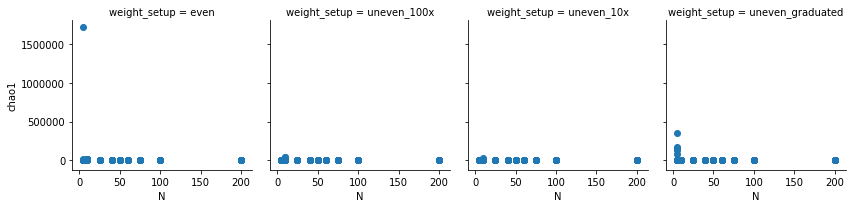

In [16]:
sns.scatterplot(x='N',y='chao1',hue='weight_setup',data=final_matrix)
plt.show()

g = sns.FacetGrid(col='weight_setup', data=final_matrix)
g.map(plt.scatter, 'N', 'chao1')
plt.show()

#### Alpha diversity: fisher_alpha

In [17]:
final_matrix['fisheralpha'] = [alpha.fisher_alpha(list(row)) for index, row in final_matrix_otus_only.iterrows()]

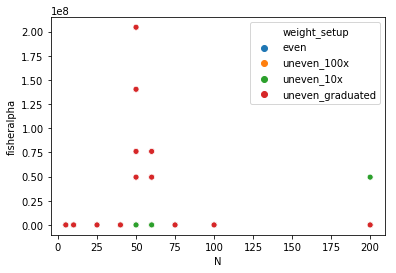

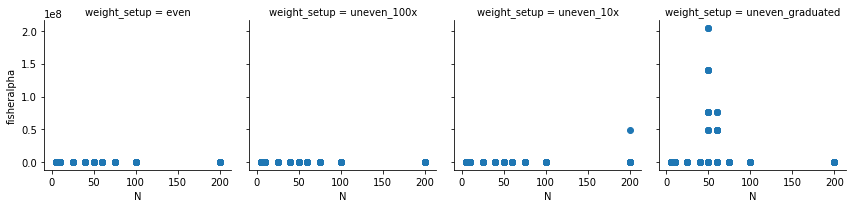

In [18]:
sns.scatterplot(x='N',y='fisheralpha',hue='weight_setup',data=final_matrix)
plt.show()

g = sns.FacetGrid(col='weight_setup', data=final_matrix)
g.map(plt.scatter, 'N', 'fisheralpha')
plt.show()